# Customer Relationship Management

In order to ensure efficiency and effectiveness in customer relations, it is necessary to first understand what the customer needs, to develop products suitable for this need, and then to present the product to the right customer, at the right time and at the right price. In this respect, CRM is the whole of the methods used by companies to make the relationship they have established with their existing or potential customers in the most efficient, effective and ultimately most profitable.

# Why use CRM?

> Retaining existing customers is less costly than acquiring new customers. Therefore, increasing the value of our existing customers is the most important way to ensure growth.

To provide a unique customer experience (CX), you will need a complete profile of your customer. You may need all kinds of data to create a customer profile. CRM techniques; It aggregates data from a variety of sources, including email, websites, physical stores, call centers, mobile sales, marketing and advertising efforts.

Knowing who your customers are, what they want, your interactions with them in the past, and what your future interactions might look like is the focus of CRM.

# Customer Lifetime Value (CLTV)

![](https://popupsmart.com/encyclopedia/user/pages/26.customer-lifetime-value-clv/customer-lifetime-value.jpg)

“It is the total expected revenue from a company's entire lifetime relationship with a customer, less any expenses incurred for the customer.

The customer value approach requires more variable and inclusive strategies rather than a static and uniform approach. Expansion, correct sales and cross-selling techniques, monitoring customer behavior, obtaining intelligence, making strategic decisions and applying are some of the methods to be used.

You should use your customer services effectively for a positive customer experience. Every contact of the customer with your brand will be an opportunity to convey the values you will add to them.

Higher customer lifetime value means more revenue for your business. Prioritize customer lifetime value to increase your profitability.

**How is Customer Lifetime Value calculated?**

The CLTV account has many calculation metrics. Basically, the metrics to focus on are;
* Average Order Value
* Purchase Frequency
* Profit Margin
* Churn Rate
* Customer Value
* Customer Life Time Value

![](https://survicate.com/wp-content/uploads/2019/05/clv-clevertap.jpg)

# Key points to successfully apply CRM techniques:

* Deliver Personalized Experiences
* Improve Your Customer Service
* Reward the Loyalty
* Build Teams That Can Successfully Implement Your Strategy
* Use Digital Channels Effectively
* Take the First Step

In this notebook, we will do the following topics step by step, respectively:
* 1-Dataset Analysis
* 2-Customer Lifetime Value Calculation
* 3-Customer Lifetime Value Prediction

As usual, we import the libraries we will use first. 

*In this prediction model we will additionally use the lifetimes library.*

In [ ]:
#pip install lifetimes

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
import seaborn as sns

# 1) Exploring the Dataset:

In [2]:
df = pd.read_csv("online_retail_II.csv")

In [3]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

**Variables**

InvoiceNo: Invoice number. It is a unique value. If this code starts with C, it means return

StockCode: Product code. It is unique for each product.

Description: Product name

Quantity: Number of products. It expresses how many of the products on the invoices have been sold. Those starting with C take a negative value.

InvoiceDate: Invoice date and time

UnitPrice: Product price

Customer ID: Customer number. It is a unique number for each customer

Country: The name of the country. Indicates the country where the customer lives.

In [4]:
df.describe().T

count          mean          std       min       25%  \
Quantity     1067371.0      9.938898   172.705794 -80995.00      1.00   
Price        1067371.0      4.649388   123.553059 -53594.36      1.25   
Customer ID   824364.0  15324.638504  1697.464450  12346.00  13975.00   

                 50%       75%      max  
Quantity         3.0     10.00  80995.0  
Price            2.1      4.15  38970.0  
Customer ID  15255.0  16797.00  18287.0

In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df["Description"].nunique()

5299

In [8]:
df["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    5315
REGENCY CAKESTAND 3 TIER              3777
ASSORTED COLOUR BIRD ORNAMENT         2794
JUMBO BAG RED RETROSPOT               2776
LUNCH BAG  BLACK SKULL.               2161
Name: Description, dtype: int64

In [9]:
df.groupby("Description").agg({"Quantity": "sum"}).sort_values(by="Quantity", ascending=False).head(10)

Quantity
Description                                 
WORLD WAR 2 GLIDERS ASSTD DESIGNS     107489
WHITE HANGING HEART T-LIGHT HOLDER     90008
ASSORTED COLOUR BIRD ORNAMENT          79434
JUMBO BAG RED RETROSPOT                74564
BROCADE RING PURSE                     70390
PACK OF 60 PINK PAISLEY CAKE CASES     55051
60 TEATIME FAIRY CAKE CASES            53169
PACK OF 72 RETROSPOT CAKE CASES        45742
PACK OF 72 RETRO SPOT CAKE CASES       44507
SMALL POPCORN HOLDER                   43602

We are only interested in values greater than zero in the Quantity and Price fields. We also do not consider canceled transactions.

In [10]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]
df = df[df['Country'] == 'United Kingdom']

We can make outlier values in variables such as Quantity and Price more appropriate with these functions.

In [11]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [12]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [13]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [14]:
df.sort_values(by = 'TotalPrice', ascending = False)

Invoice StockCode                    Description  Quantity  \
390762  526934     22790        MIRROR, ARCHED GEORGIAN     200.0   
548724  538191     22423       REGENCY CAKESTAND 3 TIER     268.5   
936693  572209     23558  LANDMARK FRAME LONDON BRIDGE      268.5   
936691  572209     23554   LANDMARK FRAME OXFORD STREET     268.5   
420628  529613     22423       REGENCY CAKESTAND 3 TIER     268.5   
...        ...       ...                            ...       ...   
123947  501176      PADS     PADS TO MATCH ALL CUSHIONS       1.0   
104480  499399      PADS     PADS TO MATCH ALL CUSHIONS       1.0   
79794   496643      PADS     PADS TO MATCH ALL CUSHIONS       1.0   
101718  499056      PADS     PADS TO MATCH ALL CUSHIONS       1.0   
77702   496473      PADS     PADS TO MATCH ALL CUSHIONS       1.0   

                InvoiceDate   Price  Customer ID         Country  TotalPrice  
390762  2010-10-14 09:46:00  19.420      18102.0  United Kingdom    3884.000  
548724  2010-12-10 10:49:00  10.950      15061.0  United Kingdom    2940.075  
936693  2011-10-21 12:08:00  10.950      18102.0  United Kingdom    2940.075  
936691  2011-10-21 12:08:00  10.950      18102.0  United Kingdom    2940.075  
420628  2010-10-29 10:46:00  10.950      17949.0  United Kingdom    2940.075  
...                     ...     ...          ...             ...         ...  
123947  2010-03-15 11:00:00   0.001      14857.0  United Kingdom       0.001  
104480  2010-02-26 13:26:00   0.001      14459.0  United Kingdom       0.001  
79794   2010-02-03 11:58:00   0.001      13408.0  United Kingdom       0.001  
101718  2010-02-24 13:46:00   0.001      13765.0  United Kingdom       0.001  
77702   2010-02-01 15:38:00   0.001      17350.0  United Kingdom       0.001  

[725250 rows x 9 columns]

# 2-Customer Lifetime Value Calculation

As a result of the following transactions and calculations, we may now calculate the value of each customer in our company.

When we evaluate our customers on an annual basis, for example, if we have the information on the annual average number of orders and how much they spend on these orders, we can calculate the Customer Life Time Value for each customer.

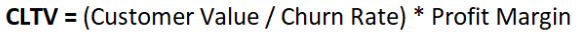

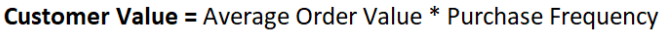

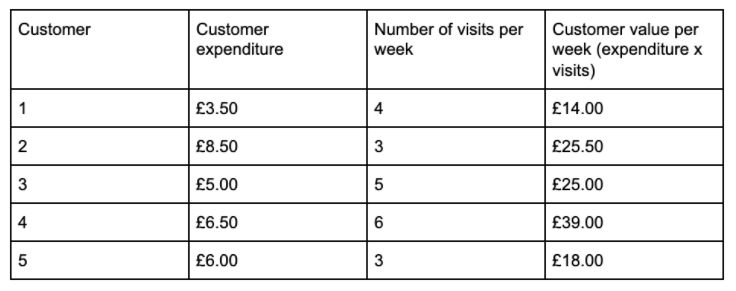

Average customer expenditures per visit (S) = £5.90 
The purchase cycle (C) = 4.2 
Average customer value / week (A) = £24.30 

When you have estimated your variables you will have to take into account some constants. These are:

**1. Average customer lifespan (T) – How long, based on your experience, do customers remain your customers?**

Calculate Churn Rate %:

CB – Customers at the beginning of a period

CE – Customers at the end of a period

If you had 100 customers at the start of the period, and 95 customers at the end of the period, your churn rate would be:

Churn rate (%) = (100-95)/100 = 5/100

= 5%

T = 1 / 5% 

= 1 / 0.05 = 20

**2. Discount rate (I) – No, this is not your customer’s discount. You are projecting a value, into the future, but you’ll have to adapt this value to present tense. Simply put – the value of a certain good in the future is lower than that of one you are holding in your hands today. This is the interest rate used in discounted cash flow analysis to determine the present value of future cash flows. Confused? Go with a standard 10% rate.**

**3. Customer retention rate (R) – How many of your customers come back to your store and purchase from you, compared to the previous, equal amount of time?**

CE = customers at the end of a period of time
CN = customers acquired during a period of time
CB = customers at the beginning of a period of time
Say you had:

CE = 95

CN = 20

CB = 100

R = ((95-20) / 100) × 100 

= (75 / 100) × 100 

= 0.75 × 100

= 75%

**4. Profit Margin (P)**

Total revenue: £500

Cost of sales: £393.45

P = ((500-393.45) / 500) x 100 = 21.3%

**5. Average Gross Margin per Customer Lifespan (M) – the gross profit per customer expected in the given average lifespan.**

M = 21.3%( 52(24.30) x 20)

=£5,382.94




Simple Customer Lifetime Value Formula: 

= 52(24.30) x 20

= £25,272


**NOTE: the number 52 comes from the number of weeks in a year.**

[1]

# However!!! 

* **This calculation will represent a single time period. It will also only represent the time the analysis was made.**

* **In these formulas, Total Price is the dominant factor and will suppress the frequency. This leads to the fact that the number of transactions will not matter once the customer has earned the same price to the company.**

* **Churn rate comes from all customer base. It will not be personal. Likewise, Profit is not specific to the customer, coming from the entire customer base.**

For all these reasons, we need a more comprehensive model. For this, we will use BG-NBD and Gamma-Gamma models.

# Let's prepare the dataset for CLTV Prediction

In [16]:
today_date = pd.to_datetime(df['InvoiceDate'].max()) + pd.DateOffset(days=2)
print(today_date)

2011-12-11 12:49:00


In [17]:
cltv_df = df.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (today_date - pd.to_datetime(InvoiceDate).max()).days,
                         lambda InvoiceDate: (today_date - pd.to_datetime(InvoiceDate).min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0             327        727       12     652.10
12608.0             406        406        1     415.79
12745.0             488        575        2     723.85
12746.0             542        542        1     254.55
12747.0               3        733       26    9276.54

* Regency = Time between current date and max (last) invoice date
* T (time) = Time between current date and min (first) invoice date
* Frequency = Number of invoices (orders)
* Monetary = Total sales

In [18]:
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

recency    T  frequency  monetary
Customer ID                                   
12346.0          327  727         12    652.10
12608.0          406  406          1    415.79
12745.0          488  575          2    723.85
12746.0          542  542          1    254.55
12747.0            3  733         26   9276.54

In [19]:
cltv_df.sort_values(by = 'monetary', ascending = False)

recency    T  frequency    monetary
Customer ID                                     
18102.0            2  740        145  508457.945
13694.0            5  736        143  189087.875
17511.0            4  739         60  175135.805
17450.0            9  439         51  155404.680
16684.0            5  733         55  133892.210
...              ...  ...        ...         ...
15913.0          535  535          1       6.300
14792.0           65   65          1       6.200
13788.0          506  506          1       3.750
16738.0          299  299          1       3.750
14095.0          724  724          1       2.950

[5350 rows x 4 columns]

We need to calculate the average profit:

In [20]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

To build our forecasting model, we need to select **customers who make us multiple purchases**.

In [21]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.head()

recency    T  frequency    monetary
Customer ID                                     
12346.0          327  727         12   54.341667
12745.0          488  575          2  361.925000
12747.0            3  733         26  356.790000
12748.0            2  736        336  156.497321
12749.0            5  522          9  764.311111

BG/NBD model asks us for *recency* and *T* **weekly**

In [22]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [23]:
cltv_df.sort_values(by = "monetary", ascending = False)

recency           T  frequency     monetary
Customer ID                                               
14091.0      93.571429   99.857143          2  4246.545000
14088.0       1.571429   60.285714         16  3977.794375
18102.0       0.285714  105.714286        145  3506.606517
14096.0       0.714286   14.714286         17  3158.964118
17450.0       1.285714   62.714286         51  3047.150588
...                ...         ...        ...          ...
17246.0      78.285714  105.571429          2    19.460000
17816.0       5.428571  103.571429          6    18.720000
14610.0      56.714286   73.571429          2    12.175000
18037.0      22.142857  105.571429         15    11.161333
16454.0       6.571429   87.428571          4     7.737500

[3876 rows x 4 columns]

**Columns We Have Created**


**Recency** : It is equal to the duration between a customers first purchase and their last purchase.

**T** (Age of the customer): It is equal to the duration between a customer's first purchase and the last day in the dataset. 

**Frequency**: The number of periods in which the customer has made a repeat purchase.

**Monetary**: The profitability value of the customer's relationship with the company.

# 3-Customer Lifetime Value Prediction

The most important issue in this section is the need to predict the potential values ​​of our new customers.

Whether our customer has just come and purchased 1–2 products, we want to assign a value to this customer. So we need to make an estimation of whether this future customer is very valuable or unimportant to us.

If we can predict this situation, we can follow a marketing strategy with the customer accordingly. In this case, making CLTV Prediction for the future is at a very important point in CRM studies. Another need here is this: Although we have the average revenue and purchasing frequency of the customer, the reason why we cannot make forward forecasts is,
For the company, we do not have the behavioral distribution of all customers. In addition, we cannot make an estimation for individuals based on this probability distribution.
With BG-NBD and Gamma-Gamma models, we will solve this problem and make forward-looking predictions.

# BG-NBD Model

![](https://miro.medium.com/max/1838/0*ZUepkV0FnvKzRsIU)

In [24]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 3876 subjects, a: 1.35, alpha: 0.05, b: 7.06, r: 0.29>

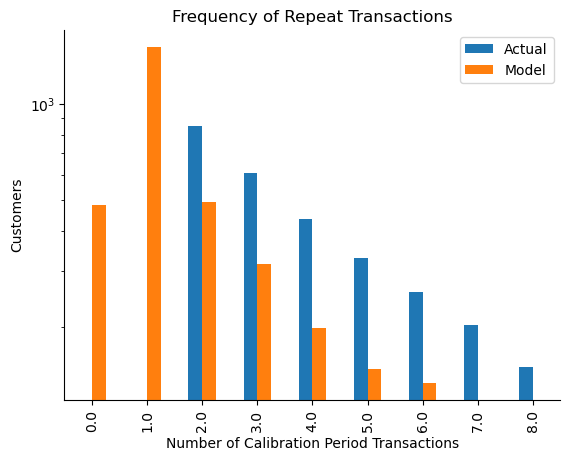

In [26]:
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

Who are the **10 customers** we expect the **most to purchase in a week?**

In [27]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
16000.0    3.360455
15060.0    2.027119
18139.0    1.827204
16479.0    1.075260
17509.0    0.729306
17100.0    0.660463
14785.0    0.650028
17523.0    0.627683
13596.0    0.571890
17461.0    0.518625
dtype: float64

Who are the **10 customers** we expect the **most to purchase in a month?**

In [28]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
16000.0    7.967858
15060.0    5.707939
18139.0    5.626592
16479.0    3.310199
17509.0    2.615684
17100.0    2.213817
14785.0    2.126422
17523.0    2.016140
13596.0    1.832921
17461.0    1.804037
dtype: float64

What is the Expected Number of Sales of the Whole Company in **3 Months?**

In [29]:
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

615.1225775367556

What is the Expected Number of Sales of the Whole Company in **1 Months?**

In [30]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

234.52469240150964

Let's add columns to the data set, where we can observe the purchasing behavior of customers in 1 week, 1 month and 3-month periods. 

> The BGNBD model only gives an idea about the purchase frequency. It does not produce a conclusion about profitability.

In [31]:
    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

 Let's bring the customers with high frequency and monetary values for 1 week projection.

In [32]:
cltv_df.sort_values("expected_purc_1_week", ascending=False).head(10)

recency         T  frequency     monetary  expected_purc_1_week  \
Customer ID                                                                     
16000.0      0.571429  0.571429          3  2167.520000              3.360455   
15060.0      1.285714  1.428571          4    75.772500              2.027119   
18139.0      2.714286  2.714286          6  1406.390000              1.827204   
16479.0      1.571429  1.571429          2   150.415000              1.075260   
17509.0      8.428571  9.142857          8   764.392500              0.729306   
17100.0      2.714286  2.714286          2   485.870000              0.660463   
14785.0      1.571429  2.285714          2    38.700000              0.650028   
17523.0      1.714286  2.857143          4   161.137500              0.627683   
13596.0      1.000000  2.000000          2   348.520000              0.571890   
17461.0      3.428571  4.428571          3   252.486667              0.518625   

             expected_purc_1_month  expected_purc_3_month  
Customer ID                                                
16000.0                   7.967858              12.365927  
15060.0                   5.707939              10.133361  
18139.0                   5.626592              10.892412  
16479.0                   3.310199               6.497238  
17509.0                   2.615684               6.231307  
17100.0                   2.213817               4.811533  
14785.0                   2.126422               4.479111  
17523.0                   2.016140               4.116741  
13596.0                   1.832921               3.765960  
17461.0                   1.804037               4.114395

# Gamma-Gamma Model

![](https://miro.medium.com/max/700/1*YjLKQnJE3wr7LQlovO78iQ.png)

It is used for the estimation of the conditional expected average profit in a certain period of time.

In [33]:
ggf = GammaGammaFitter(penalizer_coef=0.01) 
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

In [34]:
cltv_df.head()

recency           T  frequency    monetary  \
Customer ID                                                 
12346.0      46.714286  103.857143         12   54.341667   
12745.0      69.714286   82.142857          2  361.925000   
12747.0       0.428571  104.714286         26  356.790000   
12748.0       0.285714  105.142857        336  156.497321   
12749.0       0.714286   74.571429          9  764.311111   

             expected_purc_1_week  expected_purc_1_month  \
Customer ID                                                
12346.0              8.616355e-05           3.403689e-04   
12745.0              2.235285e-02           8.872537e-02   
12747.0              1.692255e-61           6.667730e-61   
12748.0              0.000000e+00           0.000000e+00   
12749.0              4.476603e-19           1.762662e-18   

             expected_purc_3_month  expected_average_profit  
Customer ID                                                  
12346.0               9.886011e-04                55.443465  
12745.0               2.608930e-01               397.729576  
12747.0               1.924221e-60               359.292016  
12748.0               0.000000e+00               156.588021  
12749.0               5.078724e-18               779.503625

There is no relationship between purchasing frequency and the calculated monetary value.
The average calculated value differs for each customer.

# Calculation of CLTV with BG-NBD and GG model.

Now let's set up a model that makes a 6-month CLTV prediction by combining our BG-NBD and Gamma-Gamma model. As a result, we will bring our customers who are most likely to shop in a 6-month projection.

In [35]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,              ### Prediction for 6 months   
                                   freq="W",            ### Frequency of T.
                                   discount_rate=0.01)

We merge the CLTV value we have calculated into the df we use. So add it as a colon.

In [36]:
cltv = cltv.reset_index()
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [37]:
cltv_final.head()

Customer ID    recency           T  frequency    monetary  \
0      12346.0  46.714286  103.857143         12   54.341667   
1      12745.0  69.714286   82.142857          2  361.925000   
2      12747.0   0.428571  104.714286         26  356.790000   
3      12748.0   0.285714  105.142857        336  156.497321   
4      12749.0   0.714286   74.571429          9  764.311111   

   expected_purc_1_week  expected_purc_1_month  expected_purc_3_month  \
0          8.616355e-05           3.403689e-04           9.886011e-04   
1          2.235285e-02           8.872537e-02           2.608930e-01   
2          1.692255e-61           6.667730e-61           1.924221e-60   
3          0.000000e+00           0.000000e+00           0.000000e+00   
4          4.476603e-19           1.762662e-18           5.078724e-18   

   expected_average_profit           clv  
0                55.443465  1.091173e-01  
1               397.729576  2.106647e+02  
2               359.292016  1.362801e-57  
3               156.588021  0.000000e+00  
4               779.503625  7.786593e-15

# Scaling CLV Values

We scale them between 1 and 0 so that the values we get can give an idea of size and smallness, so it provides us with information without any calculations.

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

Customer ID    recency          T  frequency   monetary  \
2244      16000.0   0.571429   0.571429          3  2167.5200   
3778      18139.0   2.714286   2.714286          6  1406.3900   
3349      17509.0   8.428571   9.142857          8   764.3925   
3057      17100.0   2.714286   2.714286          2   485.8700   
2068      15749.0  33.714286  47.571429          3  2724.3800   
2517      16376.0   1.428571   2.571429          2   493.5050   
951       14164.0  10.285714  11.714286          2   815.8850   
1839      15427.0   4.857143   6.857143          3   494.3800   
1518      14971.0   5.142857   6.285714          3   372.1900   
900       14091.0  93.571429  99.857143          2  4246.5450   

      expected_purc_1_week  expected_purc_1_month  expected_purc_3_month  \
2244              3.360455               7.967858              12.365927   
3778              1.827204               5.626592              10.892412   
3349              0.729306               2.615684               6.231307   
3057              0.660463               2.213817               4.811533   
2068              0.047018               0.185151               0.533713   
2517              0.499350               1.661405               3.575880   
951               0.156137               0.593793               1.584558   
1839              0.315134               1.144667               2.798662   
1518              0.388353               1.399989               3.379073   
900               0.019160               0.076155               0.224705   

      expected_average_profit           clv  scaled_clv  
2244              2299.526650  34266.340334    1.000000  
3778              1448.189646  21387.049664    0.624142  
3349               781.527226   7700.067514    0.224712  
3057               533.231626   3800.052849    0.110898  
2068              2889.958858   3037.589445    0.088646  
2517               541.578539   2847.756076    0.083107  
951                894.018339   2528.493310    0.073789  
1839               525.515686   2393.765300    0.069858  
1518               395.959044   2151.952224    0.062801  
900               4644.564655   2130.496224    0.062175

## Segmentation of Scaled CLV Values 

We divide the final values we get into segments so that we can apply different strategies for each group.

In [39]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.sort_values(by="scaled_clv", ascending=False)

Customer ID    recency           T  frequency     monetary  \
2244      16000.0   0.571429    0.571429          3  2167.520000   
3778      18139.0   2.714286    2.714286          6  1406.390000   
3349      17509.0   8.428571    9.142857          8   764.392500   
3057      17100.0   2.714286    2.714286          2   485.870000   
2068      15749.0  33.714286   47.571429          3  2724.380000   
...           ...        ...         ...        ...          ...   
1763      15311.0   0.285714  105.714286        208   560.296130   
3760      18102.0   0.285714  105.714286        145  3506.606517   
1272      14606.0   0.285714  105.428571        192   159.986615   
3         12748.0   0.285714  105.142857        336   156.497321   
197       13089.0   0.571429  105.428571        203   574.522611   

      expected_purc_1_week  expected_purc_1_month  expected_purc_3_month  \
2244              3.360455               7.967858              12.365927   
3778              1.827204               5.626592              10.892412   
3349              0.729306               2.615684               6.231307   
3057              0.660463               2.213817               4.811533   
2068              0.047018               0.185151               0.533713   
...                    ...                    ...                    ...   
1763              0.000000               0.000000               0.000000   
3760              0.000000               0.000000               0.000000   
1272              0.000000               0.000000               0.000000   
3                 0.000000               0.000000               0.000000   
197               0.000000               0.000000               0.000000   

      expected_average_profit           clv  scaled_clv segment  
2244              2299.526650  34266.340334    1.000000       A  
3778              1448.189646  21387.049664    0.624142       A  
3349               781.527226   7700.067514    0.224712       A  
3057               533.231626   3800.052849    0.110898       A  
2068              2889.958858   3037.589445    0.088646       A  
...                       ...           ...         ...     ...  
1763               560.774118      0.000000    0.000000       D  
3760              3510.762614      0.000000    0.000000       D  
1272               160.148502      0.000000    0.000000       D  
3                  156.588021      0.000000    0.000000       D  
197                575.024346      0.000000    0.000000       D  

[3876 rows x 12 columns]

To work on segments, we can group according to their mean, count and sum values. Thus, we will have obtained very useful insights for each group before the marketing actions we will take.

In [40]:
cltv_final.describe().T

count          mean          std           min  \
Customer ID              3876.0  15546.646285  1568.935952  12346.000000   
recency                  3876.0     20.677908    24.168575      0.285714   
T                        3876.0     75.131763    28.940691      0.571429   
frequency                3876.0      8.273220    13.566502      2.000000   
monetary                 3876.0    339.605823   260.834882      7.737500   
expected_purc_1_week     3876.0      0.016528     0.082728      0.000000   
expected_purc_1_month    3876.0      0.060507     0.239980      0.000000   
expected_purc_3_month    3876.0      0.158700     0.486950      0.000000   
expected_average_profit  3876.0    354.929180   270.392375      9.065075   
clv                      3876.0    104.712417   697.733938      0.000000   
scaled_clv               3876.0      0.003056     0.020362      0.000000   

                                  25%           50%           75%  \
Customer ID              1.418525e+04  15569.500000  16894.250000   
recency                  2.857143e+00      8.714286     32.714286   
T                        5.885714e+01     84.571429     98.714286   
frequency                3.000000e+00      5.000000      9.000000   
monetary                 1.922600e+02    285.070500    408.155813   
expected_purc_1_week     1.438167e-11      0.000100      0.017087   
expected_purc_1_month    5.677080e-11      0.000379      0.067774   
expected_purc_3_month    1.635167e-10      0.001105      0.198409   
expected_average_profit  2.031408e+02    299.355666    424.432250   
clv                      9.733428e-08      0.599710     88.118700   
scaled_clv               2.840522e-12      0.000018      0.002572   

                                  max  
Customer ID              18287.000000  
recency                    105.571429  
T                          105.714286  
frequency                  336.000000  
monetary                  4246.545000  
expected_purc_1_week         3.360455  
expected_purc_1_month        7.967858  
expected_purc_3_month       12.365927  
expected_average_profit   4644.564655  
clv                      34266.340334  
scaled_clv                   1.000000

# References:
[1] https://www.seedrs.com/academy/how-to-calculate-customer-lifetime-value/

[2] Fader, P. S., Hardie, B. G., & Lee, K. L. (2008). Computing P (alive) using the BG/NBD model.

[3] Jasek, P., Vrana, L., Sperkova, L., Smutny, Z., & Kobulsky, M. (2019). Comparative analysis of selected probabilistic customer lifetime value models in online shopping. Journal of Business Economics and Management, 20(3), 398-423.

[4] Venkatakrishna, M. R., Mishra, M. P., & Tiwari, M. S. P. Customer Lifetime Value Prediction and Segmentation using Machine Learning.
